# Análise da turbina eólica

## Introdução

Energia eólica é a energia cinética proveniente da força de massas de ar em movimento (ventos), que é captada pelas turbinas dos aerogeradores e convertida em eletricidade.

Este material encontra-se dividido em três etapas: 
* 1ª Etapa:Tratamento dos dados;
* 2ª Etapa: Análises dos dados e conclusões;
* 3º Etapa: Predições da energia produzida;

## Objeto de análise:

A turbina em análise está sendo ativada por massas de ar. Assim, ela está produzindo energia elétrica.

**A potência de uma turbina eólica está relacionada com alguns parâmetros:**

* velocidade do vento;
* eficiência do gerador;
* massa específica do ar;
* área do rotor.

`VELOCIDADE DO VENTO:` é o principal parâmetro analisado, pois é a partir da sua velocidade que é gerada a energia cinética que esta será convertida em energia elétrica no gerador. Por isso, a angulação do vento entre ele a turbina é um fator pontual, pois a depender a direção que o vento está, ela não irá gerar movimento nas hélices.


## Objetivos

**OBJETIVOS DA EMPRESA:** A empresa `HEnergiaRenovável` delimitou as seguintes imposições e pedidos:
* Um relatório técnico sobre a análise;
* Produção mensal de energia; OK
* Produção de energia pela hora do dia; OK
* Identificar se existe alguma correlação entre as variáveis de análise; OK
* Identificar o nível médio de saída de energia para diferentes velocidades do vento;
    * em passos de 5 m/s
* Identificar quais direções de vento produzem maiores erros; OK
* Identificar a produção mensal média do ano de 2018 do primeiro semestre;
* Gráficos de comparação entre a potência real e a potência teórica; OK
* Identificar os valores de potência zero e fazer uma análise mais detalhada;
    * Identificar os outliers e verificar se devem ser utilizados ou não.
* Gerar arquivo csv contendo os dados não nulos de potência ativa e teórica;
* Dados com 5% para mais ou para menos do limite teórico devem ser desconsiderados;
    * Gerar uma coluna de erros
* Um sistema de predição de potência produzida a partir do banco de dados.
    * Identificar a melhor forma de subdividir o dataframe.
        



## Informações sobre o dataset e limitações

O dataset nos forcene os seguintes dados:

* Data da medição - medição em intervalos de 10 minutos;
* Potência ativa em kW - potência gerada pela fonte eólica;
* Velocidade do vento em m/s;
* Potência teórica em kwH;
* Direção do vento em graus.


**FONTE:**
* https://www.kaggle.com/berkerisen/wind-turbine-scada-dataset
* https://www.kaggle.com/akdagmelih/wind-turbine-power-prediction-gbtregressor-pyspark/notebook
* https://www.kaggle.com/yohanesnuwara/wind-turbine-scada-analytics


**LIMITAÇÕES DA ANÁLISE:**
* Algumas medições não foram registradas, isto é, mesmo com velocidade de vento não foi computado o valor da potência produzida.

## Metodologia
* Para as análises e limpezada dos dados foi utilizada a linguagem de programação Python com a interface do Jupyter.

* Para as análises estatísticas foram utilizadas bibliotecas do Python.



## Importações iniciais

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools

# configurações
import warnings
warnings.filterwarnings('ignore')

# 1º ETAPA: Tratamento do dados

**IMPORTANTO O DATAFRAME E FAZENDO AS VERIFICAÇÕES**

In [5]:
turbina_df = pd.read_csv('archive/T1.csv')
turbina_df.head(3)

,Date/Time,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,01 01 2018 00:00,380.047791,5.311336,416.328908,259.994904
1,01 01 2018 00:10,453.769196,5.672167,519.917511,268.641113
2,01 01 2018 00:20,306.376587,5.216037,390.900016,272.564789


In [6]:
turbina_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50530 entries, 0 to 50529
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Date/Time                      50530 non-null  object 
 1   LV ActivePower (kW)            50530 non-null  float64
 2   Wind Speed (m/s)               50530 non-null  float64
 3   Theoretical_Power_Curve (KWh)  50530 non-null  float64
 4   Wind Direction (°)             50530 non-null  float64
dtypes: float64(4), object(1)
memory usage: 1.9+ MB


## Ajustando os nomes do DataFrame e modificando o tipo da coluna do tempo

In [7]:
# criando um dicionário para renomear as colunas
colunas = {
    'Date/Time':'data/tempo',
    'LV ActivePower (kW)':'potencia_ativa',
    'Wind Speed (m/s)':'velocidade_vento',
    'Theoretical_Power_Curve (KWh)':'potencia_teorica',
    'Wind Direction (°)':'direcao_vento'
}

# renomenado as colunas
turbina_df.rename(columns=colunas, inplace=True)

# mudando o formato da coluna do tempo para datetime
turbina_df['data/tempo'] = pd.to_datetime(turbina_df['data/tempo'])

# colocando o índice como a coluna do datetime
turbina_df.set_index('data/tempo', inplace=True)

# visualizando o dataframe modificado
turbina_df.head(3)

,potencia_ativa,velocidade_vento,potencia_teorica,direcao_vento
data/tempo,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789


In [8]:
turbina_df.describe()

,potencia_ativa,velocidade_vento,potencia_teorica,direcao_vento
count,50530.000000,50530.000000,50530.000000,50530.000000
mean,1307.684332,7.557952,1492.175463,123.687559
std,1312.459242,4.227166,1368.018238,93.443736
min,-2.471405,0.000000,0.000000,0.000000
25%,50.677890,4.201395,161.328167,49.315437
50%,825.838074,7.104594,1063.776283,73.712978
75%,2482.507568,10.300020,2964.972462,201.696720
max,3618.732910,25.206011,3600.000000,359.997589


# 2º ETAPA: Análise de dados

## 1ª - Quantidade mensal de produção de energia

Existe alguma diferença entre os meses para a produção média de energia?

In [9]:
colunas = {
    1:'Janeiro',
    2:'Fevereiro',
    3:'Março',
    4:'Abril',
    5:'Maio',
    6:'Junho',
    7:'Julho',
    8:'Agosto',
    9:'Setembro',
    10:'Outubro',
    11:'Novembro',
    12:'Dezembro'
}

# criando o dataframe dos meses
energia_mensal = turbina_df.groupby(turbina_df.index.month).mean()

# renomeando as colunas dos índices
energia_mensal.rename(index=colunas, inplace=True)

# renomeando o nome da coluna dos índices
energia_mensal.index.name = 'Meses'

# vizualizando o dataframe
energia_mensal

,potencia_ativa,velocidade_vento,potencia_teorica,direcao_vento
Meses,,,,
Janeiro,1469.538834,9.407847,2051.432742,137.723051
Fevereiro,1398.812191,8.179499,1670.969069,124.670508
Março,1778.547254,9.204149,1899.451986,157.674416
Abril,1062.471714,6.740089,1186.013869,94.857182
Maio,1099.212305,6.693869,1271.246602,104.178431
Junho,1168.209523,6.844458,1330.927093,133.941694
Julho,694.432261,5.474675,781.056052,148.386055
Agosto,1510.816574,8.050320,1695.374114,88.250307
Setembro,1491.921321,7.704346,1601.570319,107.495466


Text(0.5, 0, 'Meses')

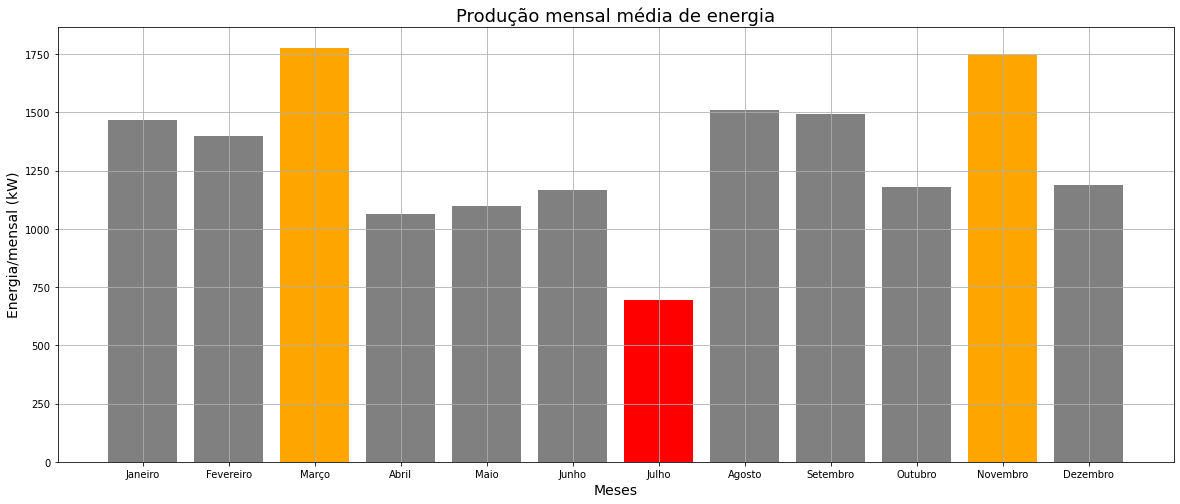

In [10]:
plt.figure(figsize=(20, 8))

color = list(np.full(12, 'grey'))
color[2], color[6], color[10] = 'orange', 'red', 'orange'

plt.grid()
plt.bar(energia_mensal.index, height=energia_mensal.potencia_ativa, color=color)

plt.title('Produção mensal média de energia', fontsize=18)
plt.ylabel('Energia/mensal (kW)', fontsize=14)
plt.xlabel('Meses', fontsize=14)

Text(0.5, 0, 'Meses')

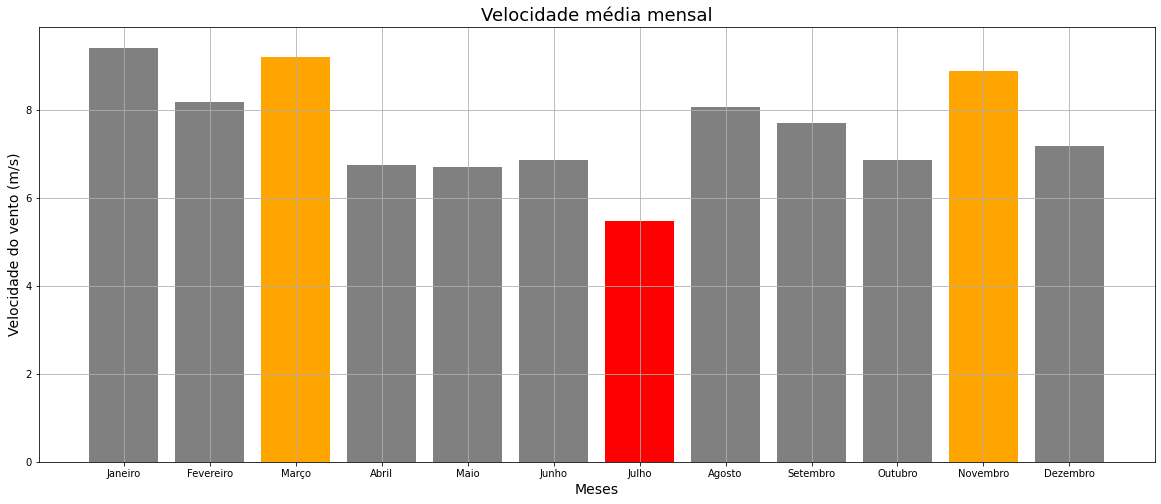

In [11]:
vento_mes = turbina_df.groupby(turbina_df.index.month).mean()

vento_mes.rename(index=colunas, inplace=True)

color = list(np.full(12, 'grey'))
color[2], color[6], color[10] = 'orange', 'red', 'orange'


plt.figure(figsize=(20, 8))
plt.grid()
plt.bar(x=vento_mes.index, height=vento_mes.velocidade_vento, color=color)
plt.title('Velocidade média mensal', fontsize=18)
plt.ylabel('Velocidade do vento (m/s)', fontsize=14)
plt.xlabel('Meses', fontsize=14)

Text(0.5, 0, 'Meses')

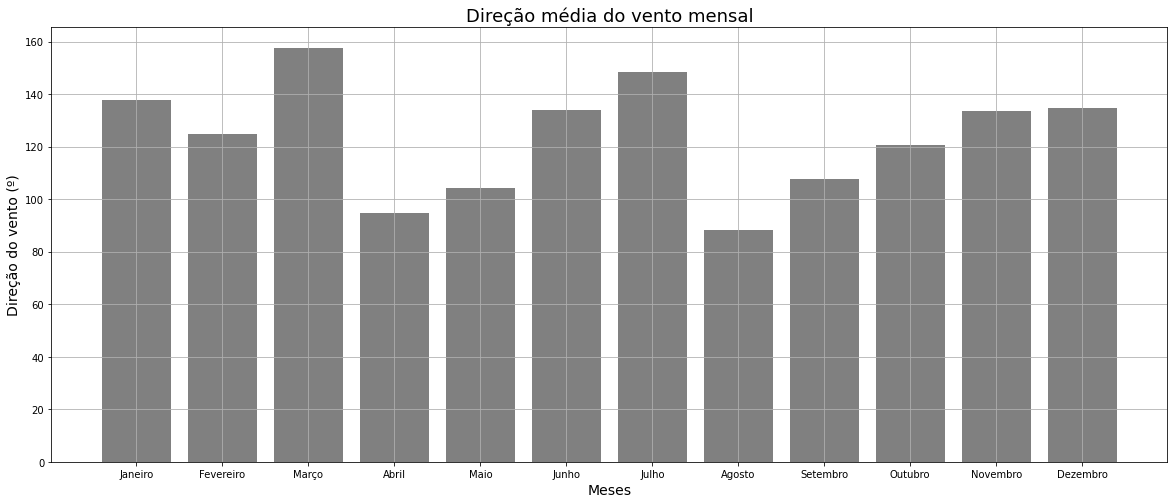

In [12]:
dir_vento_mes = turbina_df.groupby(turbina_df.index.month).mean()

dir_vento_mes.rename(index=colunas, inplace=True)

color = list(np.full(12, 'grey'))
plt.figure(figsize=(20, 8))
plt.grid()
plt.bar(x=vento_mes.index, height=vento_mes.direcao_vento, color=color)
plt.title('Direção média do vento mensal', fontsize=18)
plt.ylabel('Direção do vento (º)', fontsize=14)
plt.xlabel('Meses', fontsize=14)

**RESPOSTA:** Sim, existe uma diferença média de produção de energia. Os meses três piores meses são Julho, Maio e Abril. Sendo que nesses, o mês de menor produção é Julho. Os os meses de março e novembro têm a maior produção de energia média. Além disso, fica evidente a correlação positiva e alta entre velocidade de vento e produção de energia, ou seja, o crescimento de uma das variáveis influência no crescimento do outro. Contudo, a direção do vento é um fator importante, porém não tão impactante quanto a velocidade do vento. Portanto, conclui-se que a potência gerada pela turbina é altamente correlacionada com a velocidade do vento. (Algo que já era esperado)

**FIGURA PARA PLOTAR**

Text(0.5, 0, 'Meses')

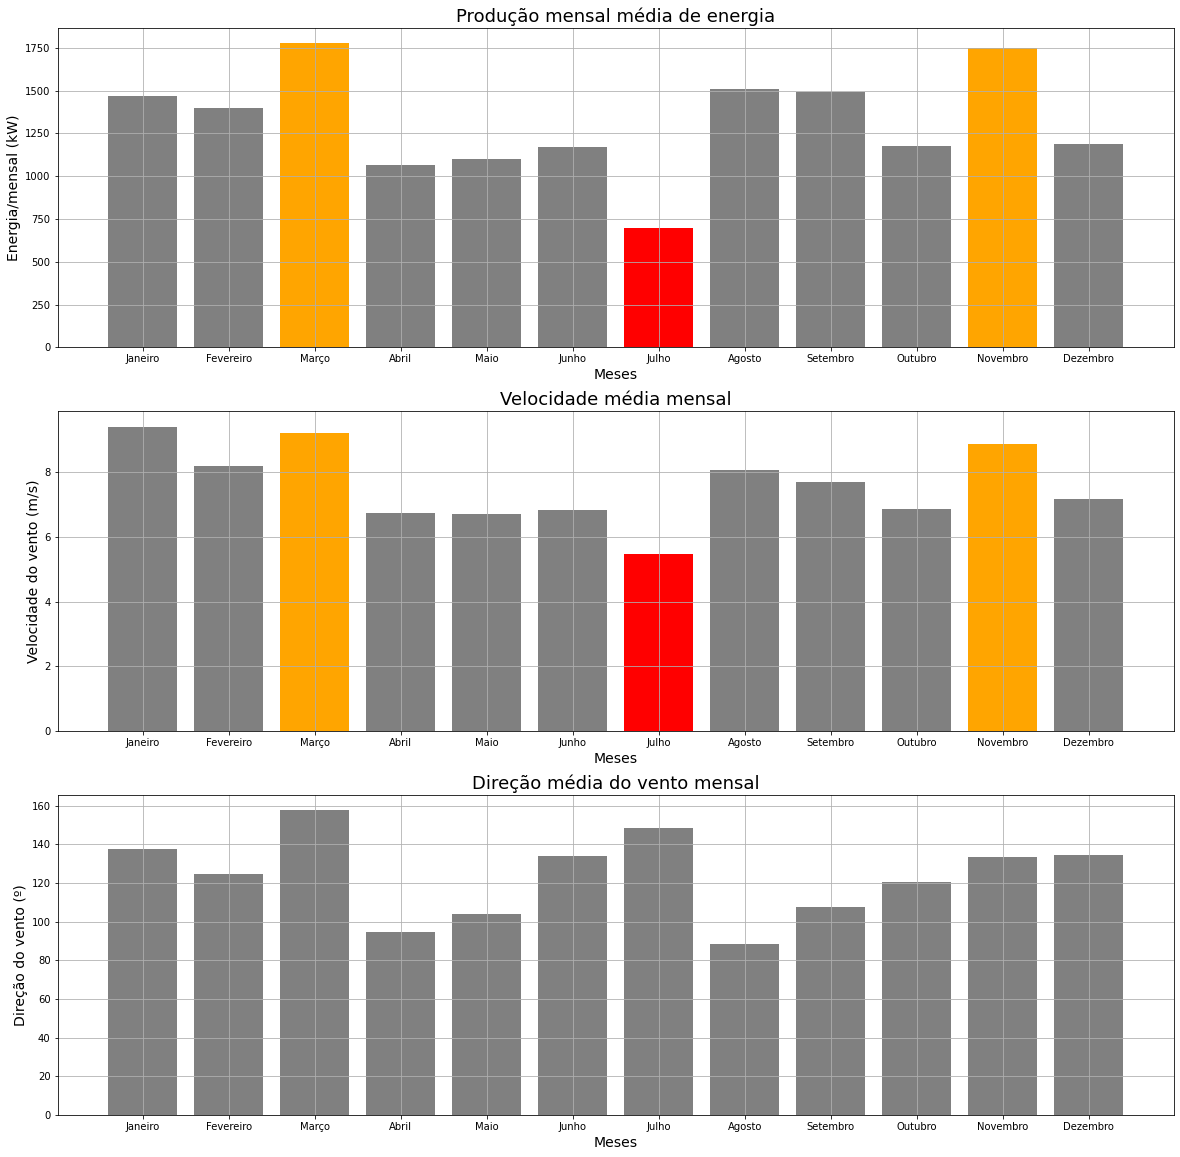

In [13]:
plt.figure(figsize=(20, 20))


# criando primeiro subplot
plt.subplot(3, 1, 1)
plt.grid()
color = list(np.full(12, 'grey'))
color[2], color[6], color[10] = 'orange', 'red', 'orange'
plt.bar(energia_mensal.index, height=energia_mensal.potencia_ativa, color=color)
plt.title('Produção mensal média de energia', fontsize=18)
plt.ylabel('Energia/mensal (kW)', fontsize=14)
plt.xlabel('Meses', fontsize=14)

# criando segundo subplot
plt.subplot(3, 1, 2)
color = list(np.full(12, 'grey'))
color[2], color[6], color[10] = 'orange', 'red', 'orange'
plt.grid()
plt.bar(x=vento_mes.index, height=vento_mes.velocidade_vento, color=color)
plt.title('Velocidade média mensal', fontsize=18)
plt.ylabel('Velocidade do vento (m/s)', fontsize=14)
plt.xlabel('Meses', fontsize=14)

# criando terceiro subplot
plt.subplot(3, 1, 3)
color = list(np.full(12, 'grey'))
plt.grid()
plt.bar(x=vento_mes.index, height=vento_mes.direcao_vento, color=color)
plt.title('Direção média do vento mensal', fontsize=18)
plt.ylabel('Direção do vento (º)', fontsize=14)
plt.xlabel('Meses', fontsize=14)


## 2ª - Quantidade diária de produção de energia

Existe alguma diferença entre as horas para a produção média de energia?

In [14]:
# agrupando o dataframe da energia produzina por hora
energia_hora = turbina_df.groupby(turbina_df.index.hour).mean()

# renomeando o nome da coluna e do índice
energia_hora.columns.name = 'features'
energia_hora.index.name = 'Hora do dia'

# visualizando o dataframe
energia_hora

features,potencia_ativa,velocidade_vento,potencia_teorica,direcao_vento
Hora do dia,,,,
0,1385.044023,7.850671,1568.735677,133.480092
1,1375.151801,7.885823,1568.980273,131.191982
2,1382.937343,7.886549,1575.770090,131.531560
3,1375.325266,7.890250,1578.654134,130.114486
4,1393.639176,7.885168,1588.432064,128.740767
5,1323.467826,7.681868,1515.403518,127.089092
6,1243.540404,7.351122,1417.321563,124.988257
7,1178.739047,7.093343,1343.307290,124.730761
8,1091.950881,6.923616,1267.907163,123.608422


* PRODUÇÃO DE ENERGIA POR HORA 

Text(0.5, 0, 'Hora')

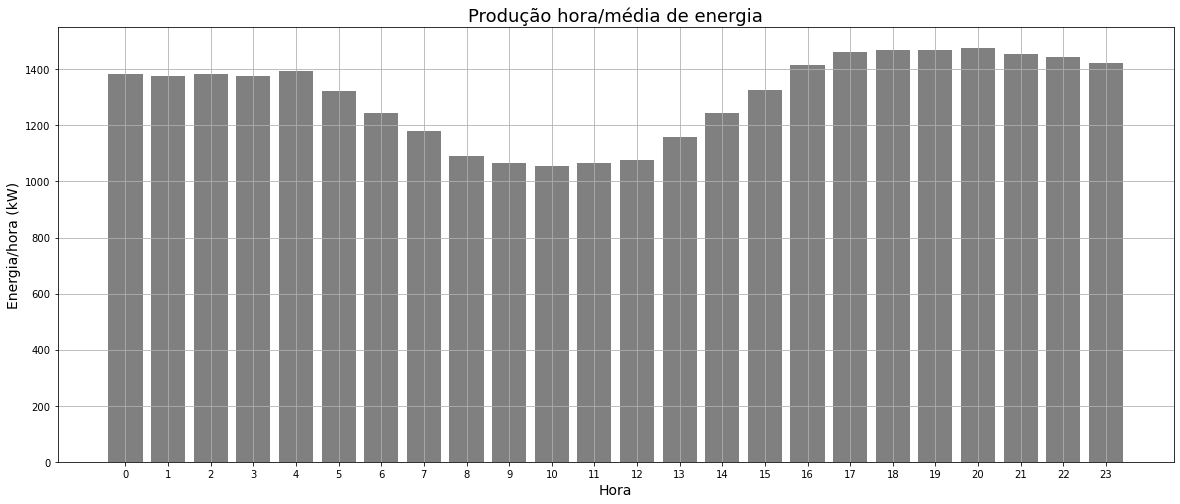

In [15]:
color = list(np.full(12, 'gray'))

plt.figure(figsize=(20, 8))
plt.grid(True)
plt.bar(x=energia_hora.index, height=energia_hora['potencia_ativa'], color=color)
plt.title('Produção hora/média de energia', fontsize=18)
plt.ylabel('Energia/hora (kW)', fontsize=14)
plt.xticks([x for x in range(24)])
plt.xlabel('Hora', fontsize=14)

* VELOCIDADE MÉDIA DO VENTO POR HORA

Text(0.5, 0, 'Hora')

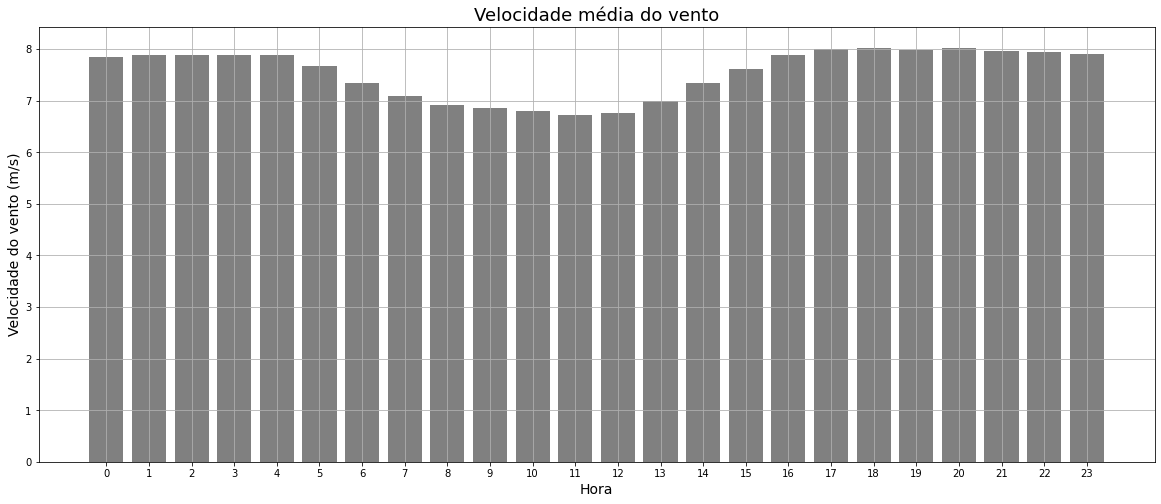

In [16]:
color = list(np.full(12, 'gray'))

plt.figure(figsize=(20, 8))
plt.grid(True)
plt.bar(x=energia_hora.index, height=energia_hora['velocidade_vento'], color=color)
plt.title('Velocidade média do vento', fontsize=18)
plt.ylabel('Velocidade do vento (m/s)', fontsize=14)
plt.xticks([x for x in range(24)])
plt.xlabel('Hora', fontsize=14)

* ANGULAÇÃO MEDIA POR HORA

Text(0.5, 0, 'Hora')

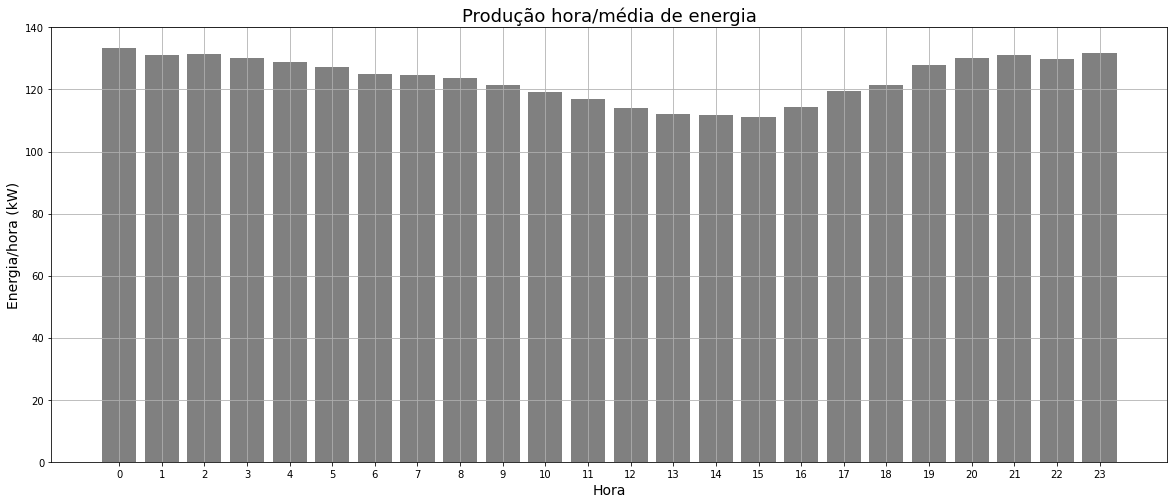

In [17]:
color = list(np.full(12, 'gray'))

plt.figure(figsize=(20, 8))
plt.grid(True)
plt.bar(x=energia_hora.index, height=energia_hora['direcao_vento'], color=color)
plt.title('Produção hora/média de energia', fontsize=18)
plt.ylabel('Energia/hora (kW)', fontsize=14)
plt.xticks([x for x in range(24)])
plt.xlabel('Hora', fontsize=14)

**RESPOSTA:** Sim, existe diferença na produção de energia na hora. A menor produção ocorre entre 8 e 12 horas e a maior produção durante 16 e 20 horas. Ademais, pode-se obter a mesmas conclusões do item 2º.

## 3ª - Existe alguma correlação entre a velocidade do vento, a direção do vento e a produção de energia?

In [18]:
plt.figure(figsize=(20, 8))
turbina_df.corr()

,potencia_ativa,velocidade_vento,potencia_teorica,direcao_vento
potencia_ativa,1.000000,0.912774,0.949918,-0.062702
velocidade_vento,0.912774,1.000000,0.944209,-0.077188
potencia_teorica,0.949918,0.944209,1.000000,-0.099076
direcao_vento,-0.062702,-0.077188,-0.099076,1.000000


<Figure size 1440x576 with 0 Axes>

**RESPOSTA:** A tabela acima só confirma os resultados verificados nos gráficos.  

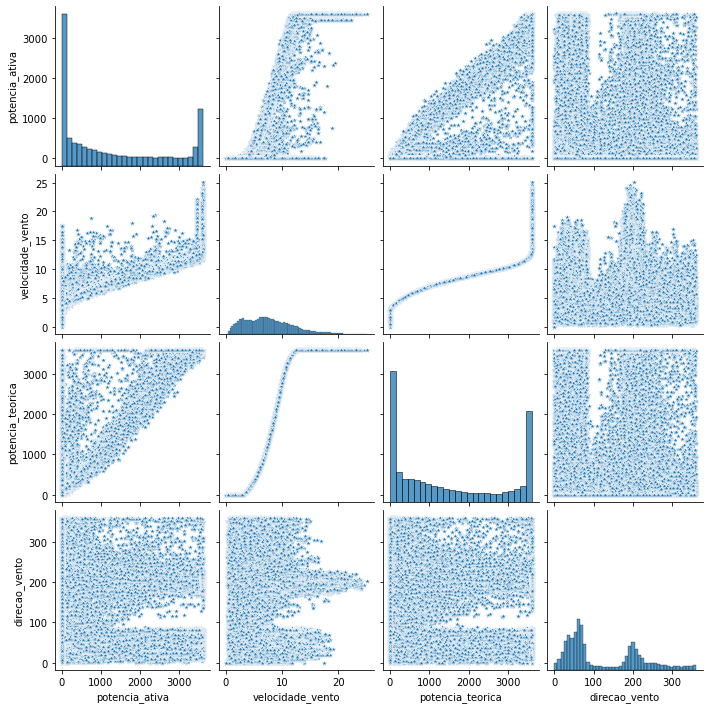

In [19]:
sns.pairplot(turbina_df, markers='*')

**RESPOSTA:** A velocidade do vento e a produção de energia estão altamente correlacionadas, como seria de esperar. Podemos ver que há produção de energia de nível inferior para algumas direções de vento.

## 4ª - Qual é o nível médio de saída de energia para diferentes velocidades do vento?

https://www.geeksforgeeks.org/pandas-cut-method-in-python/

https://pandas.pydata.org/docs/reference/api/pandas.cut.html

Text(0, 0.5, 'Produção média de energia por intervalo (kW)')

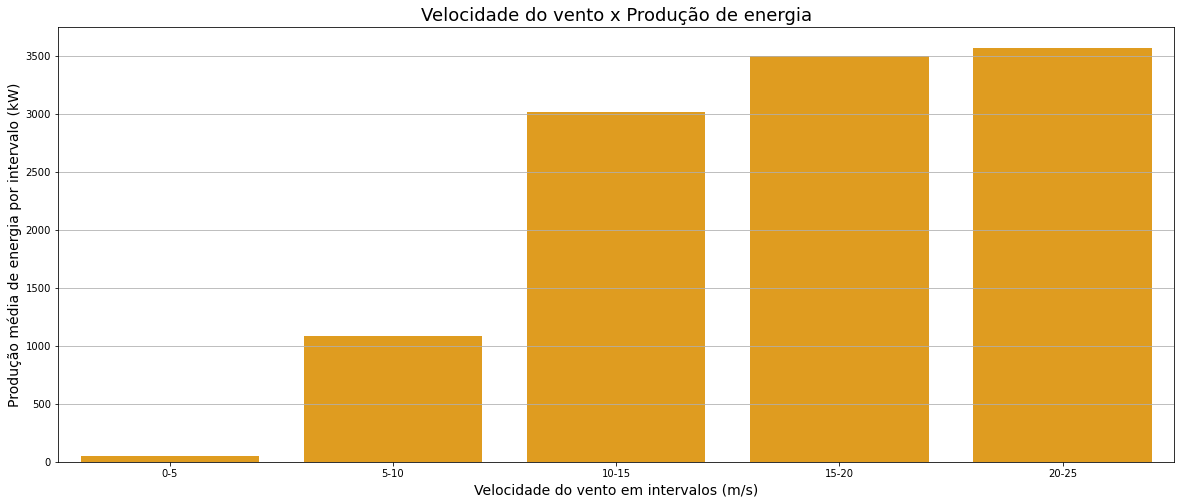

In [20]:
# Finding average power production for 5 m/s wind speed increments

# variáveis auxiliares
classes = [
    0,
    5,
    10,
    15,
    20,
    25
]

labels = ['0-5', '5-10', '10-15', '15-20', '20-25']

# criando nova coluna no df
turbina_df['classificacao_vento'] = pd.cut(x = turbina_df.velocidade_vento,
         bins = classes,
         labels = labels,
         include_lowest = True)

# agrupando os valores
agrupa_vento = turbina_df.groupby('classificacao_vento').mean()

# gerando o gráfico
plt.figure(figsize=(20, 8))
plt.grid()
sns.barplot(x=agrupa_vento.index, y='potencia_ativa', color='orange', data=agrupa_vento)
plt.title('Velocidade do vento x Produção de energia', fontsize=18)
plt.xlabel('Velocidade do vento em intervalos (m/s)', fontsize=14)
plt.ylabel('Produção média de energia por intervalo (kW)', fontsize=14)

A partir do gráfico acima pode-se perceber que a produção de energia cresce com um aumento da velocidade. Além disso, no intervalo 0-5 a produção de energia é baixíssima e de 15-20 e 20-25 há uma pouca variação na produção de energia.

## 5ª - Qual é a potência de saída para diferentes direções e velocidades do vento?

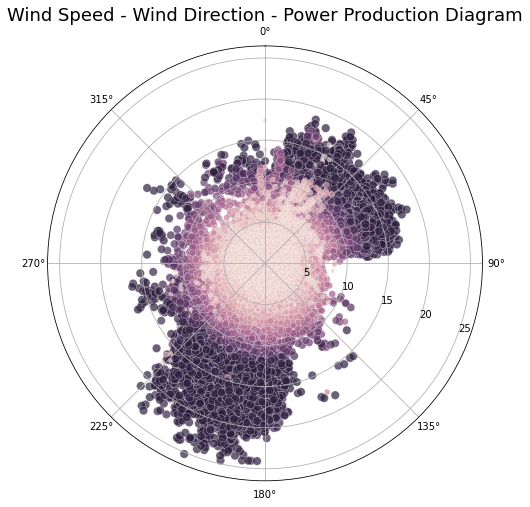

In [21]:
from math import radians

plt.figure(figsize=(20, 8))
ax = plt.subplot(111, polar=True)

# Inside circles are the wind speed and marker color and size represents the amount of power production
sns.scatterplot(x=[radians(x) for x in turbina_df.direcao_vento], 
                y=turbina_df.velocidade_vento,
                size=turbina_df.potencia_ativa,
                hue=turbina_df.potencia_ativa,
                alpha=0.7, legend=None)

# Setting the polar diagram's top represents the North 
ax.set_theta_zero_location('N')
# Setting -1 to start the wind direction clockwise
ax.set_theta_direction(-1)
# Setting wind speed labels in a better position to see
ax.set_rlabel_position(110)
plt.title('Wind Speed - Wind Direction - Power Production Diagram', fontsize=18)
plt.ylabel(None);

Text(0, 0.5, 'Direção do vento em graus º')

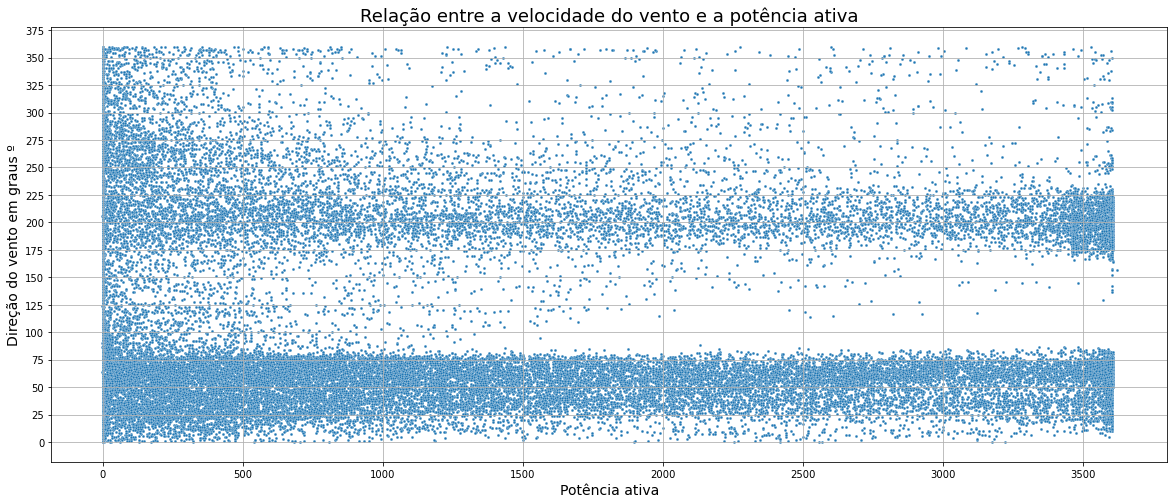

In [22]:
plt.figure(figsize=(20,8))
ax = sns.scatterplot(x=turbina_df.potencia_ativa, y=turbina_df.direcao_vento,
                     data=turbina_df, s=8)
plt.grid()
ax.set_title('Relação entre a velocidade do vento e a potência ativa', fontsize=18)
ax.set_xlabel('Potência ativa', fontsize=14)
ax.set_yticks([x for x in range(0, 400, 25)])
ax.set_ylabel('Direção do vento em graus º', fontsize=14)

As angulações entre 0-90º e 180-225º têm as maiores produções de energia.

## 6ª - Produção de energia no ano de 2018

Text(0.5, 0, 'Meses')

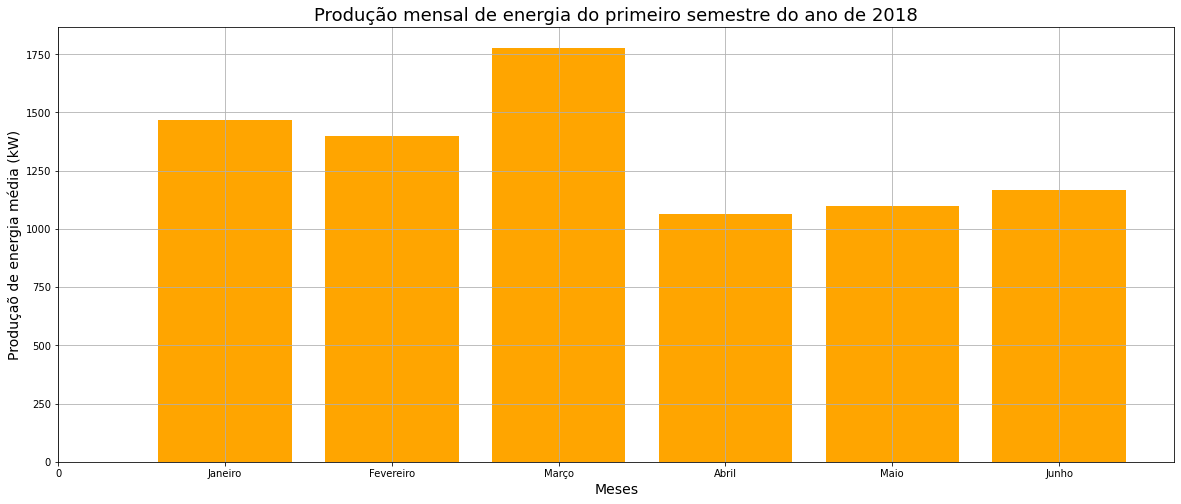

In [23]:
# criando o filtro
filtro = (turbina_df.index.year == 2018) & (turbina_df.index.month < 7)

# aplicando o filtro
turbina_2018 = turbina_df[filtro]

# agrupando pela média
agrupamento_2018 = turbina_2018.groupby(turbina_2018.index.month).mean()

# criando o gráfico de barras
plt.figure(figsize=(20, 8))
plt.grid()
plt.bar(x=agrupamento_2018.index, height=agrupamento_2018.potencia_ativa, color='orange')
plt.title('Produção mensal de energia do primeiro semestre do ano de 2018', fontsize=18)
plt.ylabel('Produçaõ de energia média (kW)', fontsize=14)
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=[0, 'Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho'])
plt.xlabel('Meses', fontsize=14)

## 7ª - Velocidade do vento e produção de energia

Nesta etapa vamos verificar como a potência teórica e ativa se comportam com o aumento da velocidade do vendo.

Text(0.5, 0, 'Potência produzida (kW)')

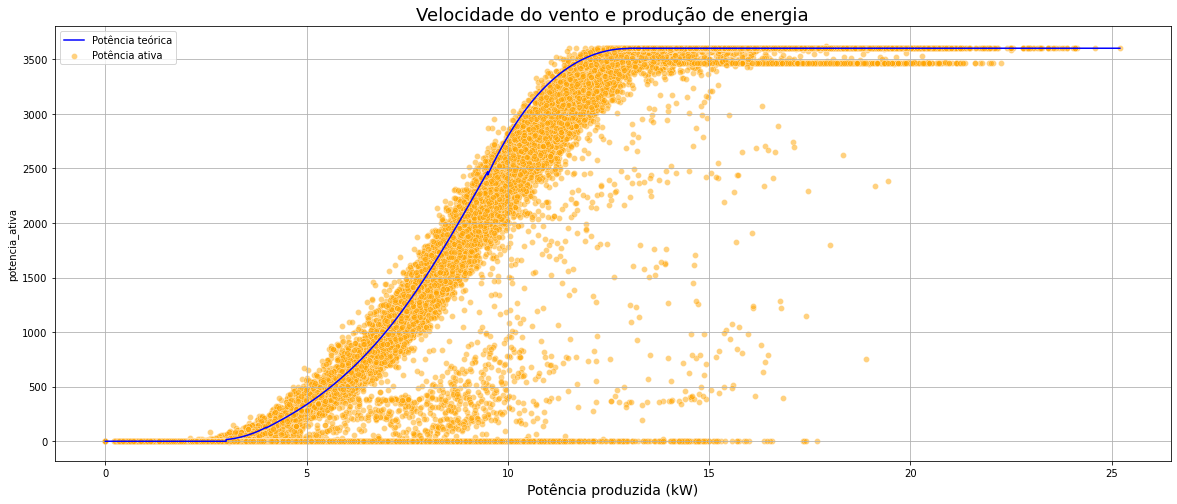

In [24]:
plt.figure(figsize=(20, 8))


sns.scatterplot(x=turbina_df.velocidade_vento, y=turbina_df.potencia_ativa,
                     data=turbina_df, color='orange', alpha=0.5, label='Potência ativa')

sns.lineplot(x=turbina_df.velocidade_vento, y=turbina_df.potencia_teorica,
             data=turbina_df, color='blue', label='Potência teórica')

plt.grid()
plt.title("Velocidade do vento e produção de energia", fontsize=18)
plt.xlabel("Velocidade do vento (m/s)", fontsize=14)
plt.xlabel("Potência produzida (kW)", fontsize=14)

**TEÓRICO**

A relação entre a `velocidade do vento` e a `potência teórica` é positiva, isto é, o aumento da velocidade causa o aumento da potência. Além disso, observar-se que a potência tem um limite máximo, isto é, a partir da velocidade de 11 m/s, a potência produzida alcança o seu valor máximo e existe uma velocidade mínima para começar a produzir potência.

<hr>

**REAL**

A relação entre a `velocidade do vento` e a `potência ativa` é positiva, isto é, o aumento da velocidade causa o aumento da potência. Além disso, observar-se que a potência tem um limite máximo, isto é, a partir da velocidade de 11 m/s, a potência produzida alcança o seu valor máximo e existe uma velocidade mínima para começar a produzir potência. Cabe salientar que, existem muitas medições zeradas, pois no momento da aferição não foi possível captar a potência produzida, apesar de haver velocidades de vento com energia suficiente para produzir energia.


A partir do gráfico acima, podemos ver que a curva teórica de produção de energia geralmente se encaixa bem com a produção real.

Podemos ver que a produção de energia atinge um nível máximo e continua em linha reta se a velocidade do vento atingir 15 m/s.

Também podemos ver que existem cerca de 0 potência de saída, mesmo a velocidade do vento é superior a 5 m / s. Quero investigar o motivo.

Mas antes qual é a velocidade mínima do vento para a curva teórica de produção de energia?

**COMPARAÇÃO ENTRE A POTÊNCIA TEÓRICA E REAL**

De forma geral, encontra-se muita mais potências abaixo dos valores teóricos do que acima.

Pode-se analisar de uma forma bem rúde a potência:

$P = v_{vento}.\eta_{rotor}$

onde:

$\eta_{rotor}$ considera-se como valor constante;

$v_{vento}$ é um valor variável.

Portanto, nos pontos em que a potência supera a teoria pode-se considerar que alguns parâmetro relacionado ao vento influênciou nesse resultado como também uma aferição errônea. Já nos pontos em que o valor real está abaixo do valor teórico, considera-se normal, pois é esperada a perda de energia devido ao rendimento do motor e perdas por atrito.

<hr>

### Qual é o valor limite da velocidade do vento para potência teórica zero?

Text(0, 0.5, 'Distribuição para 0 produção de energia')

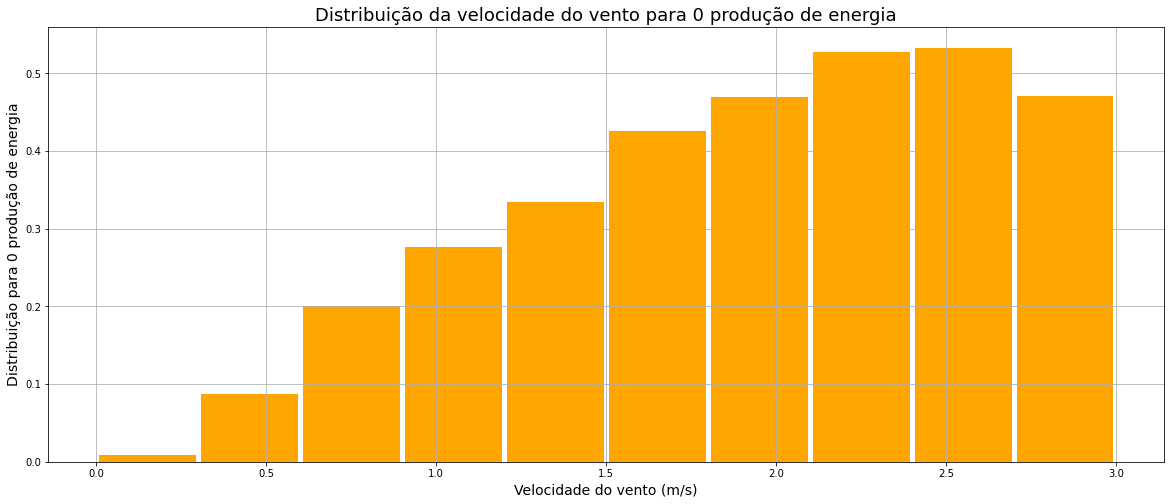

In [25]:
# criando o dataframe
potencia_zero = turbina_df.query(expr='(potencia_teorica == 0) and (potencia_ativa == 0)')

# plotando o histograma
plt.figure(figsize=(20, 8))
plt.grid()
plt.hist(x=potencia_zero.velocidade_vento, density=True, rwidth=0.95, color='orange')
plt.title('Distribuição da velocidade do vento para 0 produção de energia', fontsize=18)
plt.xlabel('Velocidade do vento (m/s)', fontsize=14)
plt.ylabel('Distribuição para 0 produção de energia', fontsize=14)

Podemos ver pelo gráfico acima, o limite para a curva de potência teórica é de 3 m/s de velocidade do vento. Se a velocidade do vento for inferior a 3 m/s, o modelo não prevê qualquer produção de energia.

Mas existem algumas observações para produção de energia 0, mesmo que a velocidade do vento seja superior a 3 m / s.

### Por que não há produção de energia em algumas observações enquanto a velocidade do vento é superior a 3 m/s?

Text(0, 0.5, 'Distribuição para 0 produção de energia')

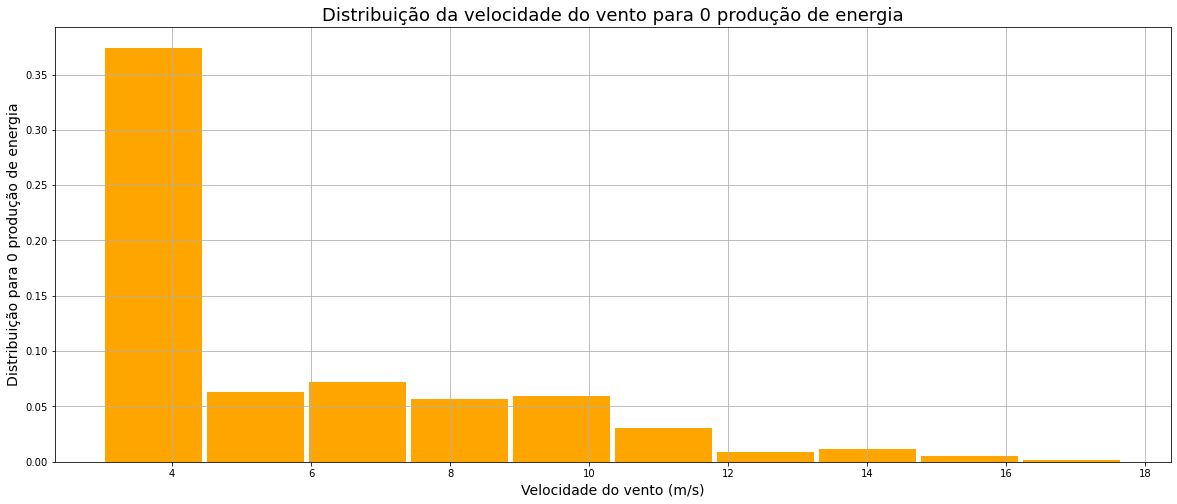

In [26]:
# criando o dataframe
potencia_zero = turbina_df.query(expr='(potencia_teorica != 0) and (potencia_ativa == 0) and (velocidade_vento > 3)')

# criando o histograma
plt.figure(figsize=(20, 8))
plt.grid()
plt.hist(x=potencia_zero.velocidade_vento, density=True, rwidth=0.95, color='orange')
plt.title('Distribuição da velocidade do vento para 0 produção de energia', fontsize=18)
plt.xlabel('Velocidade do vento (m/s)', fontsize=14)
plt.ylabel('Distribuição para 0 produção de energia', fontsize=14)

In [27]:
print(f'Existem {potencia_zero.shape[0]} registros onde a velocidade do vento é superior a 3 m/s e não tem potência sendo produzida/registrada')

Existem 3497 registros onde a velocidade do vento é superior a 3 m/s e não tem potência sendo produzida/registrada


In [28]:
columns = turbina_df.columns
columns

Index(['potencia_ativa', 'velocidade_vento', 'potencia_teorica',
       'direcao_vento', 'classificacao_vento'],
      dtype='object')

Parece que teoricamente o limite de velocidade do vento deve ser de 4 m/s. Mas também há outras observações com produção de energia zero enquanto a velocidade do vento é maior.

Assim, nesta análise estes registros serão considerados outliers.


### Verificando outros outliers

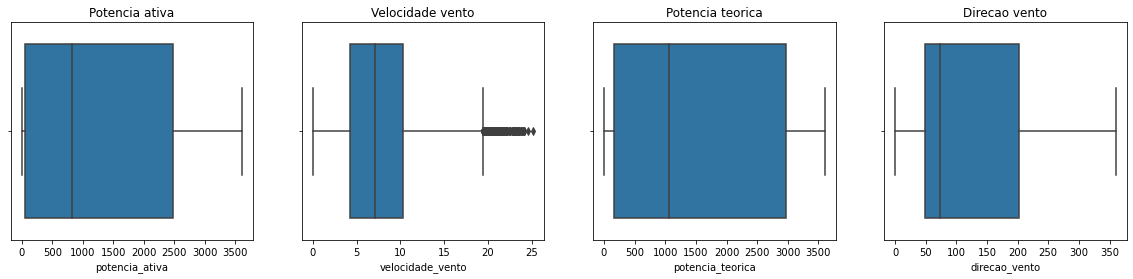

In [29]:
columns = ['potencia_ativa', 'velocidade_vento', 'potencia_teorica',
       'direcao_vento']
i=1

plt.figure(figsize=(20, 4))
for each in columns:
    df = turbina_df[each]
    plt.subplot(1, 4, i)
    sns.boxplot(df)
    plt.title(each.upper().replace('_',' ').capitalize())
    i += 1

Pelo gráfico acima é possível inferir que a velocidade do vento tem alguns valores que devem ser investigados.

In [30]:
# Defining the quantiles and interquantile range
Q1 = turbina_df.velocidade_vento.quantile(0.25)
Q3 = turbina_df.velocidade_vento.quantile(0.75)
IQR = Q3-Q1
# Defining the lower and upper threshold values
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

print('Quantile (0.25): ', Q1, '  Quantile (0.75): ', Q3)
print('Lower threshold: ', lower, ' Upper threshold: ', upper)

Quantile (0.25):  4.201395392417902   Quantile (0.75):  10.30001997947685
Lower threshold:  -4.946541488170519  Upper threshold:  19.447956860065272


In [31]:
# Fancy indexing for outliers
outlier_tf = ((turbina_df.velocidade_vento < lower) | (turbina_df.velocidade_vento > upper))

In [32]:
print('Total Number of Outliers: ', turbina_df.velocidade_vento[outlier_tf].shape[0])
print('--'*15)
print('Some Examples of Outliers:')
turbina_df.velocidade_vento[outlier_tf].sample(10).to_frame()

Total Number of Outliers:  423
------------------------------
Some Examples of Outliers:


,velocidade_vento
data/tempo,
2018-01-04 02:00:00,21.142811
2018-02-02 06:00:00,20.183750
2018-04-02 14:30:00,19.823050
2018-04-02 06:10:00,22.811171
2018-04-02 02:30:00,20.098289
2018-07-03 02:50:00,20.548849
2018-12-24 16:10:00,20.564859
2018-03-02 03:50:00,19.470400
2018-03-02 09:40:00,20.068830


Pergunta: Quais são os critérios gerais para a produção de energia?
É importante entender o padrão nos dados. Devemos aprender os dados antes da máquina.

1. Vimos pelo gráfico que em março, agosto e novembro, a produção média de energia é maior.

2. A potência média é maior diariamente entre as 16:00 e as 24:00.

3. A potência é maior quando o vento sopra das direções entre 000-090 e 180-225 graus.

Então, vamos tentar prever um nível alto e baixo de produção de energia a partir dos critérios acima antes do algoritmo ML.

Text(0, 0.5, 'Potencia ativa $(kw)$')

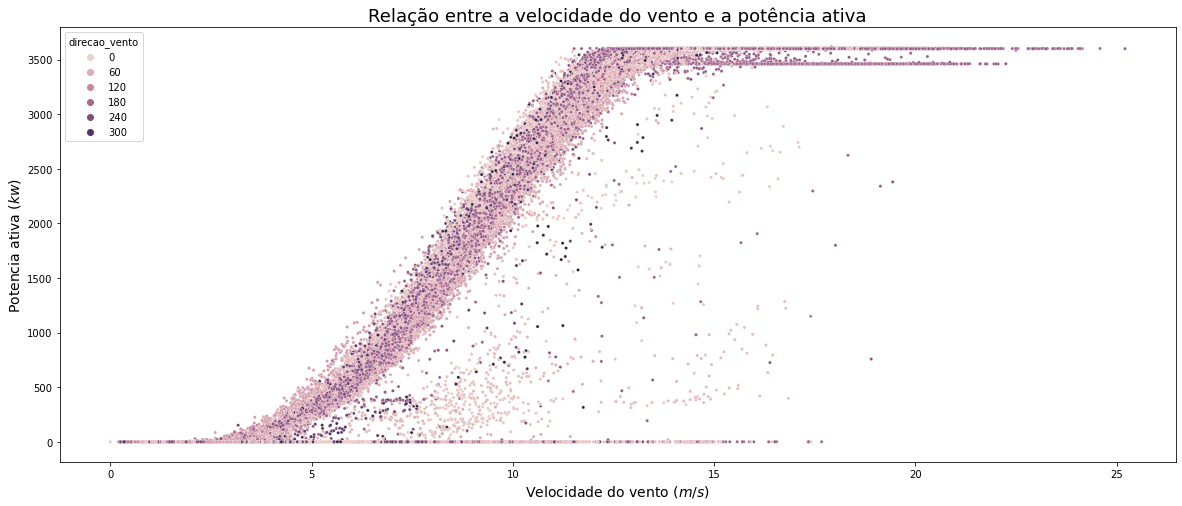

In [33]:
plt.figure(figsize=(20,8))
ax = sns.scatterplot(x=turbina_df.velocidade_vento, y=turbina_df.potencia_ativa,
                     data=turbina_df, hue=turbina_df.direcao_vento, s=10)

ax.set_title('Relação entre a velocidade do vento e a potência ativa', fontsize=18)
ax.set_xlabel('Velocidade do vento $(m/s)$', fontsize=14)
ax.set_ylabel('Potencia ativa $(kw)$', fontsize=14)

In [34]:
turbina_df['erro'] = round((abs(turbina_df.potencia_ativa - turbina_df.potencia_teorica) / turbina_df.potencia_teorica)*100, 2)

In [35]:
turbina_df.sample(3)

,potencia_ativa,velocidade_vento,potencia_teorica,direcao_vento,classificacao_vento,erro
data/tempo,,,,,,
2018-01-23 14:00:00,309.944214,8.180095,1634.75406,27.411610,5-10,81.04
2018-03-21 16:50:00,3604.249023,14.176170,3600.00000,216.710693,10-15,0.12
2018-02-03 06:30:00,3461.812012,16.062759,3600.00000,192.567795,15-20,3.84


In [36]:
turbina_df.erro.describe()

count    43246.0000
mean            inf
std             NaN
min          0.0000
25%          4.4025
50%         12.3300
75%         22.3500
max             inf
Name: erro, dtype: float64

In [37]:
potencia_zero = turbina_df[turbina_df.potencia_ativa == 0]
potencia_zero.head(10)

,potencia_ativa,velocidade_vento,potencia_teorica,direcao_vento,classificacao_vento,erro
data/tempo,,,,,,
2018-03-01 15:40:00,0.0,3.743307,83.986265,245.068207,0-5,100.0
2018-03-01 16:10:00,0.0,2.142016,0.000000,234.762405,0-5,NaN
2018-03-01 16:20:00,0.0,2.501406,0.000000,223.308807,0-5,NaN
2018-03-01 16:30:00,0.0,2.668578,0.000000,226.051697,0-5,NaN
2018-03-01 16:40:00,0.0,3.034003,17.180593,221.086502,0-5,100.0
2018-03-01 16:50:00,0.0,3.197354,25.431221,232.679596,0-5,100.0
2018-03-01 17:00:00,0.0,3.907811,110.979604,241.973099,0-5,100.0
2018-04-01 12:40:00,0.0,2.888112,0.000000,0.000000,0-5,NaN
2018-04-01 12:50:00,0.0,2.386636,0.000000,139.275101,0-5,NaN


In [38]:
potencia_sem_zero = turbina_df[turbina_df.potencia_ativa != 0]
potencia_sem_zero.head()

,potencia_ativa,velocidade_vento,potencia_teorica,direcao_vento,classificacao_vento,erro
data/tempo,,,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,5-10,8.71
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,5-10,12.72
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,5-10,21.62
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,5-10,18.69
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,5-10,22.59


Text(0, 0.5, 'Potencia ativa $(kw)$')

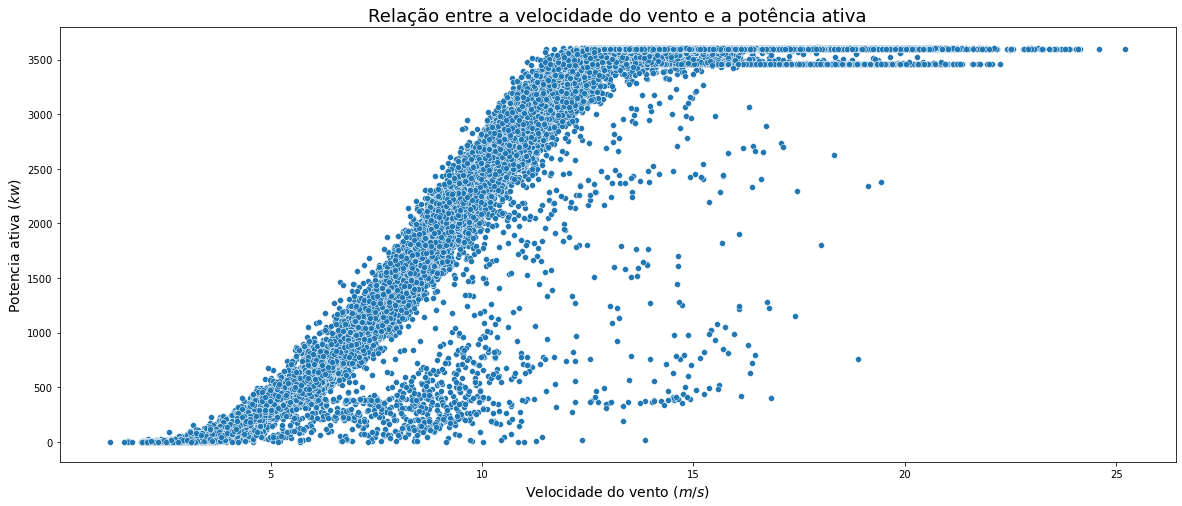

In [39]:
plt.figure(figsize=(20,8))
ax = sns.scatterplot(x='velocidade_vento', y='potencia_ativa',
                     data=potencia_sem_zero)

ax.set_title('Relação entre a velocidade do vento e a potência ativa', fontsize=18)
ax.set_xlabel('Velocidade do vento $(m/s)$', fontsize=14)
ax.set_ylabel('Potencia ativa $(kw)$', fontsize=14)

## 8ª - Filtrando os valores de 5% acima e abaixo 

A empresa pediu um df com o filtro de 5% para cima e para baixo

In [40]:
# transformando as Series em listas
pot_real= turbina_df.potencia_ativa.tolist()
pot_teorica = turbina_df.potencia_teorica.tolist()

# variáveis auxiliares
pot_max=[]
pot_min=[]
dentro_limite = []

# limite
i = 5

for potencia in pot_teorica:
    pot_max.append(potencia*(1 + i/100))
    pot_min.append(potencia*(1 - i/100))

for p, potencia in enumerate(pot_real):
    if potencia>=pot_min[p] and potencia<=pot_max[p]:
        dentro_limite.append('potencia_dentro_do_limite')
    elif potencia==0:
        dentro_limite.append('potencia_igual_0')
    else:
        dentro_limite.append('potencia_fora_do_limite')

turbina_df['limite'] = dentro_limite

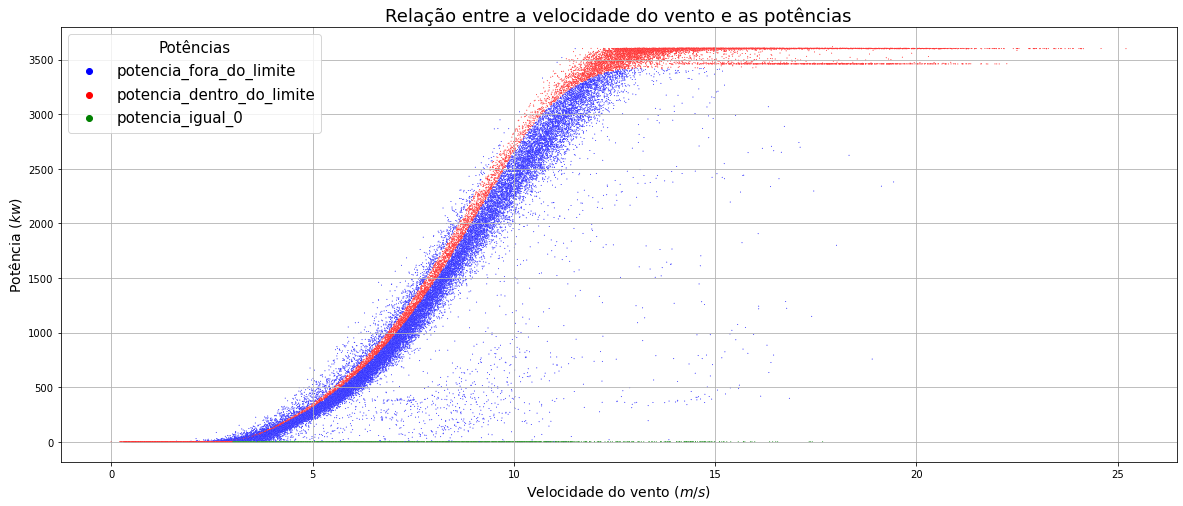

In [41]:
plt.figure(figsize=(20, 8))
plt.grid(True)

cores = {
    'potencia_dentro_do_limite':'red',
    'potencia_igual_0':'green',
    'potencia_fora_do_limite':'blue'
}
ax = sns.scatterplot(x=turbina_df.velocidade_vento, y=turbina_df.potencia_ativa,
                     data=turbina_df, hue=turbina_df.limite, s=1,
                    palette=cores)

ax.set_title('Relação entre a velocidade do vento e as potências', fontsize=18)
ax.set_xlabel('Velocidade do vento $(m/s)$', fontsize=14)
ax.set_ylabel('Potência $(kw)$', fontsize=14)
plt.legend(title='Potências', title_fontsize=15, prop={'size': 15})

In [42]:
potencias_limite = turbina_df[turbina_df.limite == 'potencia_dentro_do_limite']
potencias_limite.head()

,potencia_ativa,velocidade_vento,potencia_teorica,direcao_vento,classificacao_vento,erro,limite
data/tempo,,,,,,,
2018-01-01 02:40:00,742.985291,6.378913,759.434537,266.593292,5-10,2.17,potencia_dentro_do_limite
2018-01-01 02:50:00,748.229614,6.446653,785.281010,265.571808,5-10,4.72,potencia_dentro_do_limite
2018-01-01 03:00:00,736.647827,6.415083,773.172863,261.158691,5-10,4.72,potencia_dentro_do_limite
2018-01-01 03:10:00,787.246216,6.437531,781.771216,257.560211,5-10,0.70,potencia_dentro_do_limite
2018-01-01 03:20:00,722.864075,6.220024,700.764700,255.926498,5-10,3.15,potencia_dentro_do_limite


### Verificando a relação entre potência e velocidade do vento

Text(0, 0.5, 'Direção do vento')

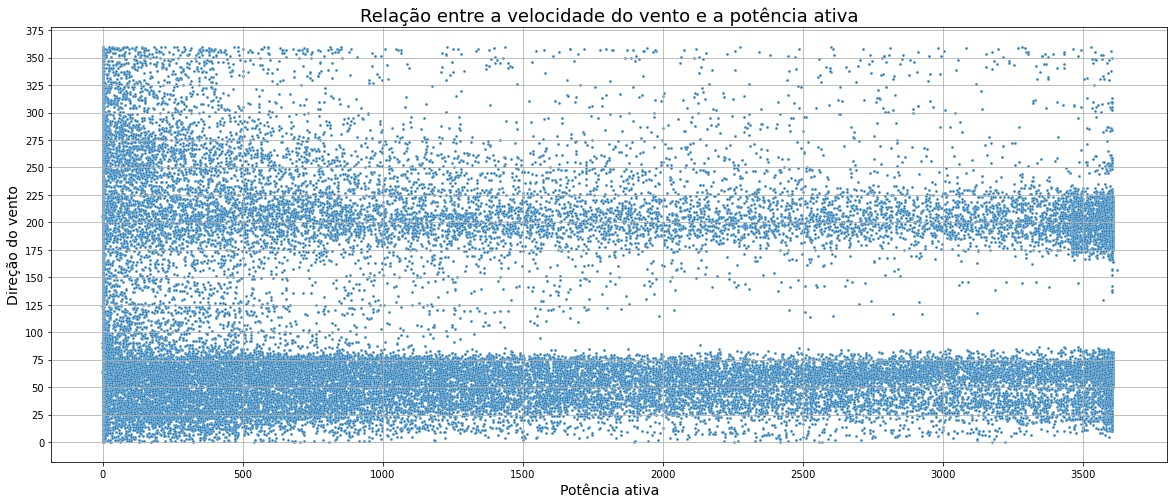

In [43]:
plt.figure(figsize=(20,8))
ax = sns.scatterplot(x=turbina_df.potencia_ativa, y=turbina_df.direcao_vento,
                     data=turbina_df, s=8)

plt.grid()
ax.set_title('Relação entre a velocidade do vento e a potência ativa', fontsize=18)
ax.set_xlabel('Potência ativa', fontsize=14)
ax.set_yticks([x for x in range(0, 400, 25)])
ax.set_ylabel('Direção do vento', fontsize=14)

TypeError: unsupported operand type(s) for +: 'NoneType' and 'int'

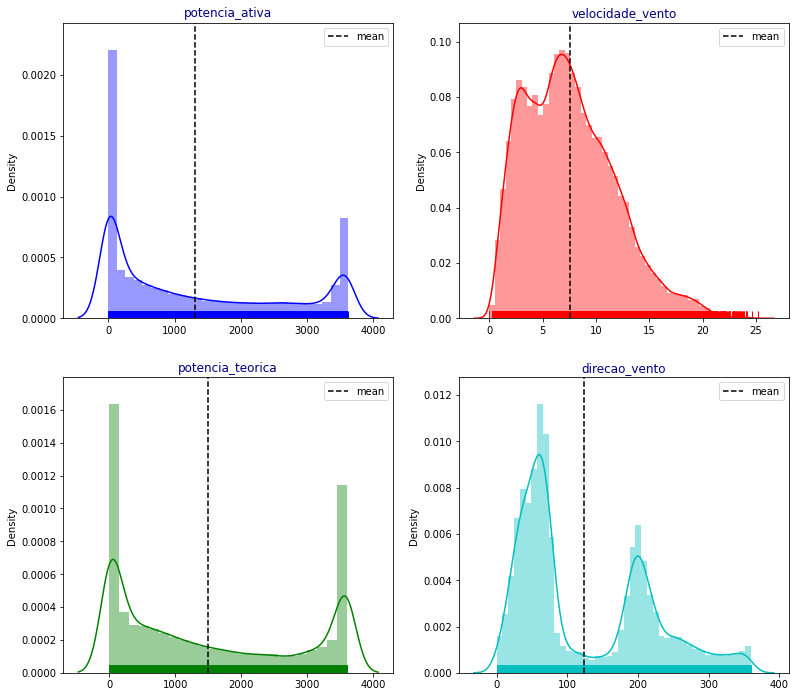

In [44]:
cols = [i for i in turbina_df.columns if i not in ['classificacao_vento', 'erro', 'limite']]

cols = ['potencia_ativa', 'velocidade_vento', 'potencia_teorica','direcao_vento']
        
length = len(cols)
cs = ["b", "r", "g", "c", "m", "k", "lime", "c"]
fig = plt.figure(figsize=(13,25))

for i,j,k in itertools.zip_longest(cols, range(length), cs):
    plt.subplot(4,2,j+1)
    ax = sns.distplot(turbina_df[i], color=k, rug=True)
    ax.set_facecolor("w")
    plt.axvline(turbina_df[i].mean(), linestyle="dashed", label="mean", color="k")
    plt.legend(loc="best")
    plt.title(i, color="navy")
    plt.xlabel("")

## CONCLUSÕES GERAIS:

Os critérios gerais para a produção de energia são:

1. Vimos pelo gráfico que em março, agosto e novembro, a produção média de energia é maior;

2. A potência média é maior diariamente entre as 16:00 e as 24:00;

3. A velocidade do vento e potência ativa estão altamente correlacionadas;

4. A potência é maior quando o vento sopra das direções entre 000-090 e 180-225 graus.

5. O limite de produção de energia teórico tem uma velocidade de vento de 3 m/s, porém na realidade o observado foi de 4 m/s;


## 3º - MODELAGEM PREDITIVA

O objetivo inicial desta modelagem preditiva é encontrar o melhor modelo para inferir qual vai ser a potência produzina com dados de entrada: a velocidade e direção do vento. Não se levou em consideração a variável do tempo, pois o foco não foi fazer uma predição no próximo valor.

## Ajustando o DataFrame original e removendo os outliers

In [45]:
turbina_df.sample(3)

,potencia_ativa,velocidade_vento,potencia_teorica,direcao_vento,classificacao_vento,erro,limite
data/tempo,,,,,,,
2018-01-01 17:00:00,2118.389893,9.098683,2207.79282,223.960907,5-10,4.05,potencia_dentro_do_limite
2018-08-26 09:20:00,0.000000,2.946398,0.00000,42.411789,0-5,NaN,potencia_dentro_do_limite
2018-04-29 09:00:00,0.000000,2.322312,0.00000,159.543106,0-5,NaN,potencia_dentro_do_limite


In [46]:
predict_df = turbina_df.loc[:, ['potencia_ativa', 'velocidade_vento' ,'direcao_vento']].copy()
predict_df.head()

,potencia_ativa,velocidade_vento,direcao_vento
data/tempo,,,
2018-01-01 00:00:00,380.047791,5.311336,259.994904
2018-01-01 00:10:00,453.769196,5.672167,268.641113
2018-01-01 00:20:00,306.376587,5.216037,272.564789
2018-01-01 00:30:00,419.645905,5.659674,271.258087
2018-01-01 00:40:00,380.650696,5.577941,265.674286


## Seleção e separação das variáveis

<hr>

* Variável Y: Potência ativa

<hr>

* Variável X1: Velocidade do vento
* Variável X2: Direção do vento
* Variável X3: período de tempo **NÃO SERÁ CONSIDERADA**

<hr>

In [47]:
X = predict_df.drop(columns = 'potencia_ativa', axis=1)
y = predict_df.potencia_ativa

* Separando as amostras para treino e teste

In [48]:
from sklearn.model_selection import train_test_split, cross_val_score

# Separando as variáves de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=50)

* Importanto a bibliotecas para o pré-processamento

https://scikit-learn.org/stable/modules/preprocessing.html#standardization-or-mean-removal-and-variance-scaling

In [49]:
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import OneHotEncoder

# # fazendo o preprocessamento dos dados
# scaler = MinMaxScaler()
# X = scaler.fit_transform(X)


## Métricas de avaliação

As [métricas](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) de avaliação para modelos regressivos são as seguintes:

*  **R2**


$R^{2}(y, \hat{y})= 1 - \frac{\sum_{i=1}^{n}(y_{i} - \hat{y_{i}})^{2}}{\sum_{i=1}^{n}(y_{i} - \bar{y_{i}})^{2}}$

The best possible score is 1.0, lower values are worse.

*  **MAE**

Como o próprio nome sugere, o MAE calcula o erro médio absoluto entre os valores
reais e os previstos. Ela retorna um valor não negativo, que quanto mais próximo de 0 indica que
os valores previstos encontram-se bem próximos dos reais. O cálculo do MAE é realizado com a a seguinte expressão:

$\text{MAE}(y, \hat{y}) = \frac{1}{n_{amostras}} \sum_{i=0}^{n_{amostras}-1} |y_{i} - \hat{y_{i}}|$

* **MSE**

Mais próximo de zero, melhor o modelo.

$\text{MSE}(y, \hat{y}) = \frac{1}{n_{amostras}} \sum_{i=0}^{n_{amostras}-1} (y_{i} - \hat{y_{i}})^{2}$

* **Explained variance**

$explained\_variance (y, \hat{y}) = 1 - \frac{Var(y - \hat{y})}{Var(y)}  $

The best possible score is 1.0, lower values are worse.

In [63]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import explained_variance_score as evc

def validar_modelo(y_test, y_pred):
    i = 3
    print('      Métricas')
    print('***'*6)
    print(f' R2 : {round(r2_score(y_test, y_pred), i)}')
    print(f' EVC: {round(evc(y_test, y_pred), i)}')
    print('---'*6)
    print(f' MAE: {round(mae(y_test, y_pred), i)}')
    print(f' MSE: {round(mse(y_test, y_pred), i)}')
    print('***'*6)

## Suport Machine Vector 

https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html

https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVR.html#sklearn.svm.LinearSVR

In [64]:
%%time
from sklearn.svm import SVR

svc = SVR()
svc.fit(X_train, y_train)
validar_modelo(y_test, svc.predict(X_test))

      Métricas
******************
 R2 : 0.002
 EVC: 0.115
------------------
 MAE: 1033.939
 MSE: 1718386.522
******************
Wall time: 2min 45s


**O resultado para SMV padrão é muito ruim, por isso será desconsiderado na análise.**

In [52]:
%%time
from sklearn.svm import LinearSVR

lsvm = LinearSVR()
lsvm.fit(X_train, y_train)
validar_modelo(y_test, lsvm.predict(X_test))

 R2: 0.8224767401566502
 MAE: 384.61882414248174
 MSE: 305803.4610962634
 EVC: 0.8230305059492493
Wall time: 1.78 s


## K-MEANS

In [53]:
%%time
from sklearn.neighbors import KNeighborsRegressor

kn = KNeighborsRegressor(n_neighbors=10)
kn.fit(X_train, y_train)
validar_modelo(y_test, kn.predict(X_test))

 R2: 0.9034683033725354
 MAE: 171.82752592528414
 MSE: 166286.53034099293
 EVC: 0.9034720627886885
Wall time: 194 ms


## Linear Regression - Regressão Linear

In [54]:
%%time
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
validar_modelo(y_test, lr.predict(X_test))

 R2: 0.8275737023542262
 MAE: 390.76178475388406
 MSE: 297023.37964400183
 EVC: 0.8275796014516147
Wall time: 22.9 ms


R2: 0.9034683033725354
 MAE: 171.82752592528414
 MSE: 166286.53034099293
Wall time: 112 ms

## Decision Tree - Árvore de decisão



In [55]:
%%time
from sklearn.tree import DecisionTreeRegressor

dt = DecisionTreeRegressor(max_depth=4)
dt.fit(X_train, y_train)
validar_modelo(y_test, dt.predict(X_test))

 R2: 0.9019302035716411
 MAE: 176.4680301837279
 MSE: 168936.07746535286
 EVC: 0.9019431577589968
Wall time: 80.9 ms


 R2: 0.9019302035716411
 MAE: 176.4680301837279
 MSE: 168936.07746535286
 Wall time: 48.8 ms


## Random Forest - Floreasta aleatória

In [56]:
%%time
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_depth=7, n_estimators=200)
rf.fit(X_train, y_train)
validar_modelo(y_test, rf.predict(X_test))

 R2: 0.9086594649279575
 MAE: 161.83876414132828
 MSE: 157344.18007005518
 EVC: 0.9086688540274235
Wall time: 8.63 s


## Escolha do melhor modelo

In [57]:
predict_df['predicao_random_forest'] = rf.predict(X)

<AxesSubplot:xlabel='velocidade_vento', ylabel='potencia_ativa'>

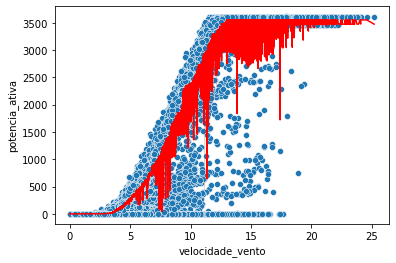

In [58]:
sns.scatterplot(x='velocidade_vento', y='potencia_ativa', data=predict_df )
sns.lineplot(x='velocidade_vento', y='predicao_random_forest', data=predict_df, color='red')

## Deploy

In [59]:
modelo_escolhido = rf.fit(X_train, y_train)

In [60]:
features = ['Velocidade do vento (m/s): ', 'Direção do vento (º): ']
f_values = []

for i in features:
    feature = float(input(f'{i}'))
    f_values.append(feature)

ar_predict = [f_values]


modelo_escolhido.predict(ar_predict)[0]

Velocidade do vento (m/s):  5
Direção do vento (º):  6


276.1061536798512